In [10]:
import numpy as np
import pandas as pd
import pylab as pl

%matplotlib inline

filename_test = 'test.csv'
filename_train = 'train.csv'
filename_store = 'store.csv'

train = pd.read_csv(filename_train, header=0, low_memory=False)

test = pd.read_csv(filename_test, header=0, low_memory=False)


store = pd.read_csv(filename_store, header=0, low_memory=False)



In [11]:
train['Date'] = pd.to_datetime(train['Date'])

test['Date'] = pd.to_datetime(test['Date'])


In [12]:
def print_missing_stats():
    for data_name, data in {'TRAIN': train, 'TEST': test, 'STORE': store}.items():
        print(data_name, ' (overall = %d)' % len(data))
        for attribute in data.columns:
            mask = data[attribute].isnull()
            k = len(data[attribute][mask].tolist())
            print('%5d (%2d%%)' % (k, 100*k/len(data)), 'missing values in ', attribute) 
        print()
print_missing_stats()

STORE  (overall = 1115)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  StoreType
    0 ( 0%) missing values in  Assortment
    3 ( 0%) missing values in  CompetitionDistance
  354 (31%) missing values in  CompetitionOpenSinceMonth
  354 (31%) missing values in  CompetitionOpenSinceYear
    0 ( 0%) missing values in  Promo2
  544 (48%) missing values in  Promo2SinceWeek
  544 (48%) missing values in  Promo2SinceYear
  544 (48%) missing values in  PromoInterval

TEST  (overall = 41088)
    0 ( 0%) missing values in  Id
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
   11 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

TRAIN  (overall = 1017209)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Sales
 

In [13]:
test.loc('Open')[test['Open'].isnull()] = 0

distance_series = store['CompetitionDistance']
since_month = store['CompetitionOpenSinceMonth']
since_year = store['CompetitionOpenSinceYear']
store.loc('CompetitionDistance')[distance_series.isnull()] = distance_series.mean()
store.loc('CompetitionOpenSinceMonth')[since_month.isnull()] = int(since_month.mode())
store.loc('CompetitionOpenSinceYear')[since_year.isnull()] = int(since_year.mode())

print_missing_stats()

STORE  (overall = 1115)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  StoreType
    0 ( 0%) missing values in  Assortment
    0 ( 0%) missing values in  CompetitionDistance
    0 ( 0%) missing values in  CompetitionOpenSinceMonth
    0 ( 0%) missing values in  CompetitionOpenSinceYear
    0 ( 0%) missing values in  Promo2
  396 (35%) missing values in  Promo2SinceWeek
  396 (35%) missing values in  Promo2SinceYear
  396 (35%) missing values in  PromoInterval

TEST  (overall = 41088)
    0 ( 0%) missing values in  Id
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

TRAIN  (overall = 1017209)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Sales
 

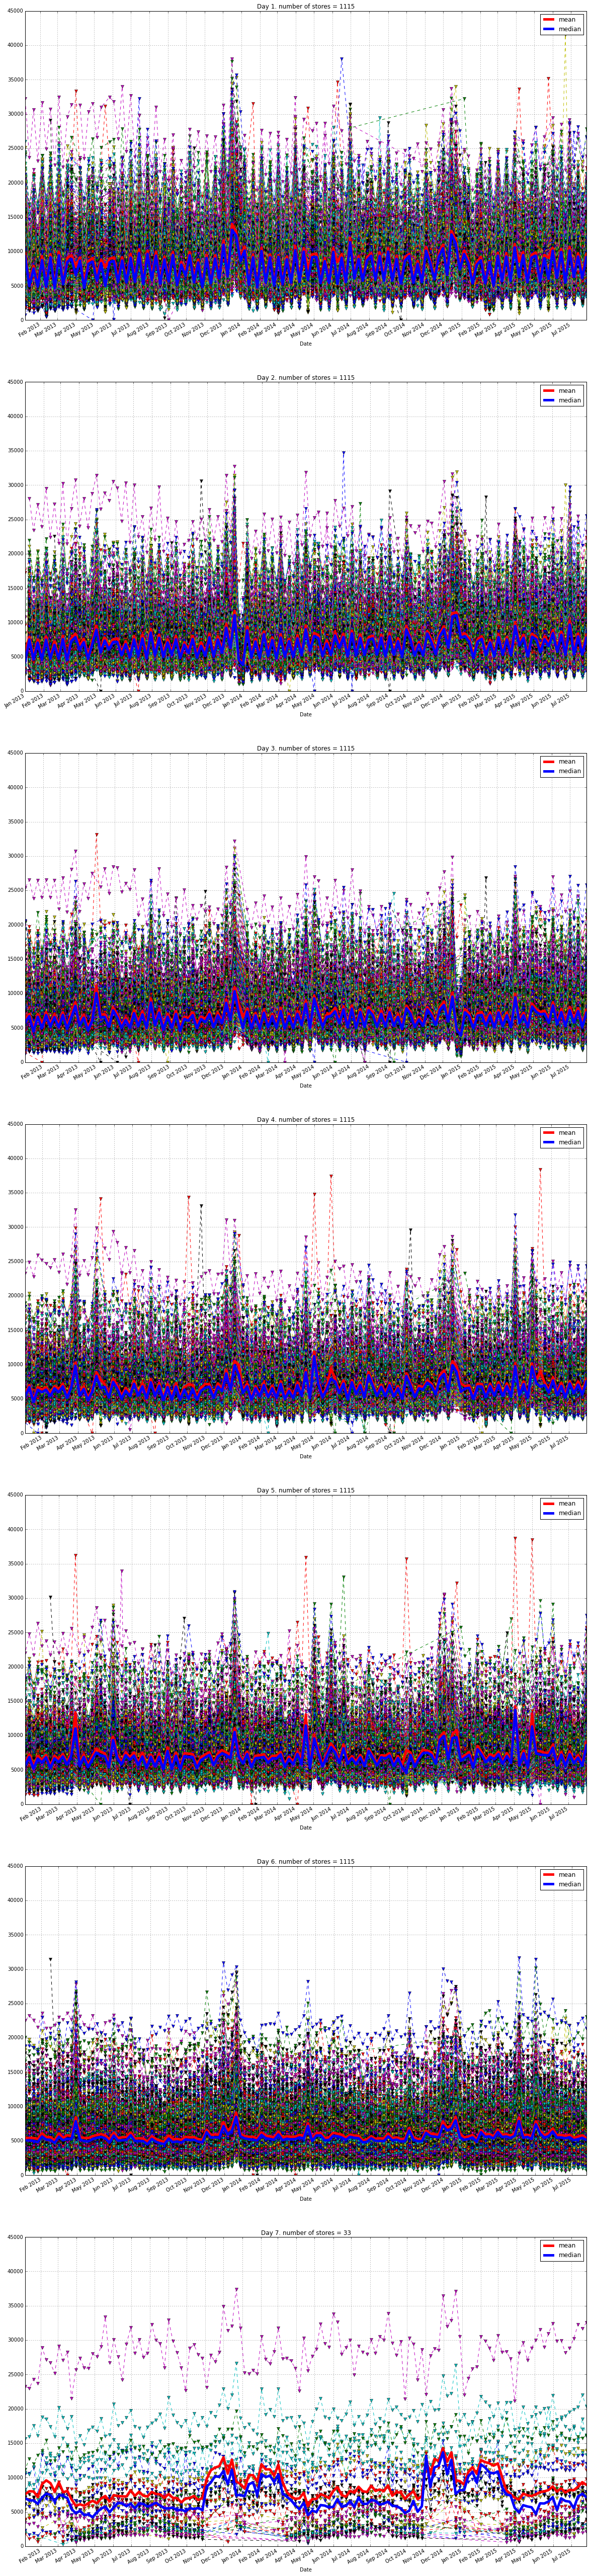

In [14]:
from matplotlib.dates import MonthLocator
fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

for day_of_week in range(1, 8):
    custom_df = train[(train['Open'] == 1) & (train['DayOfWeek'] == day_of_week)]
    gp_store = custom_df.groupby('Store')

    for store, group in gp_store:
        axes[day_of_week - 1].plot(group['Date'], group['Sales'], 'v--')

#     for store, group in gp_store:
#         ts_ewma = pd.ewma(group['Sales'], com=7)
#         axes[day_of_week - 1].plot(group['Date'], ts_ewma, 'v--')

    gp_date = custom_df.groupby('Date')

    ts_mean = gp_date['Sales'].mean()
    ts_median = gp_date['Sales'].median()
    ts_mean.plot(style='r-', linewidth=5, ax=axes[day_of_week - 1], label='mean')
    ts_median.plot(style='b-', linewidth=5, ax=axes[day_of_week - 1], label='median')


    axes[day_of_week - 1].set_title('Day ' + str(day_of_week) + '. number of stores = ' + str(len(gp_store)))
    axes[day_of_week - 1].legend()
    axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
    axes[day_of_week - 1].grid(True)
del fig
del axes

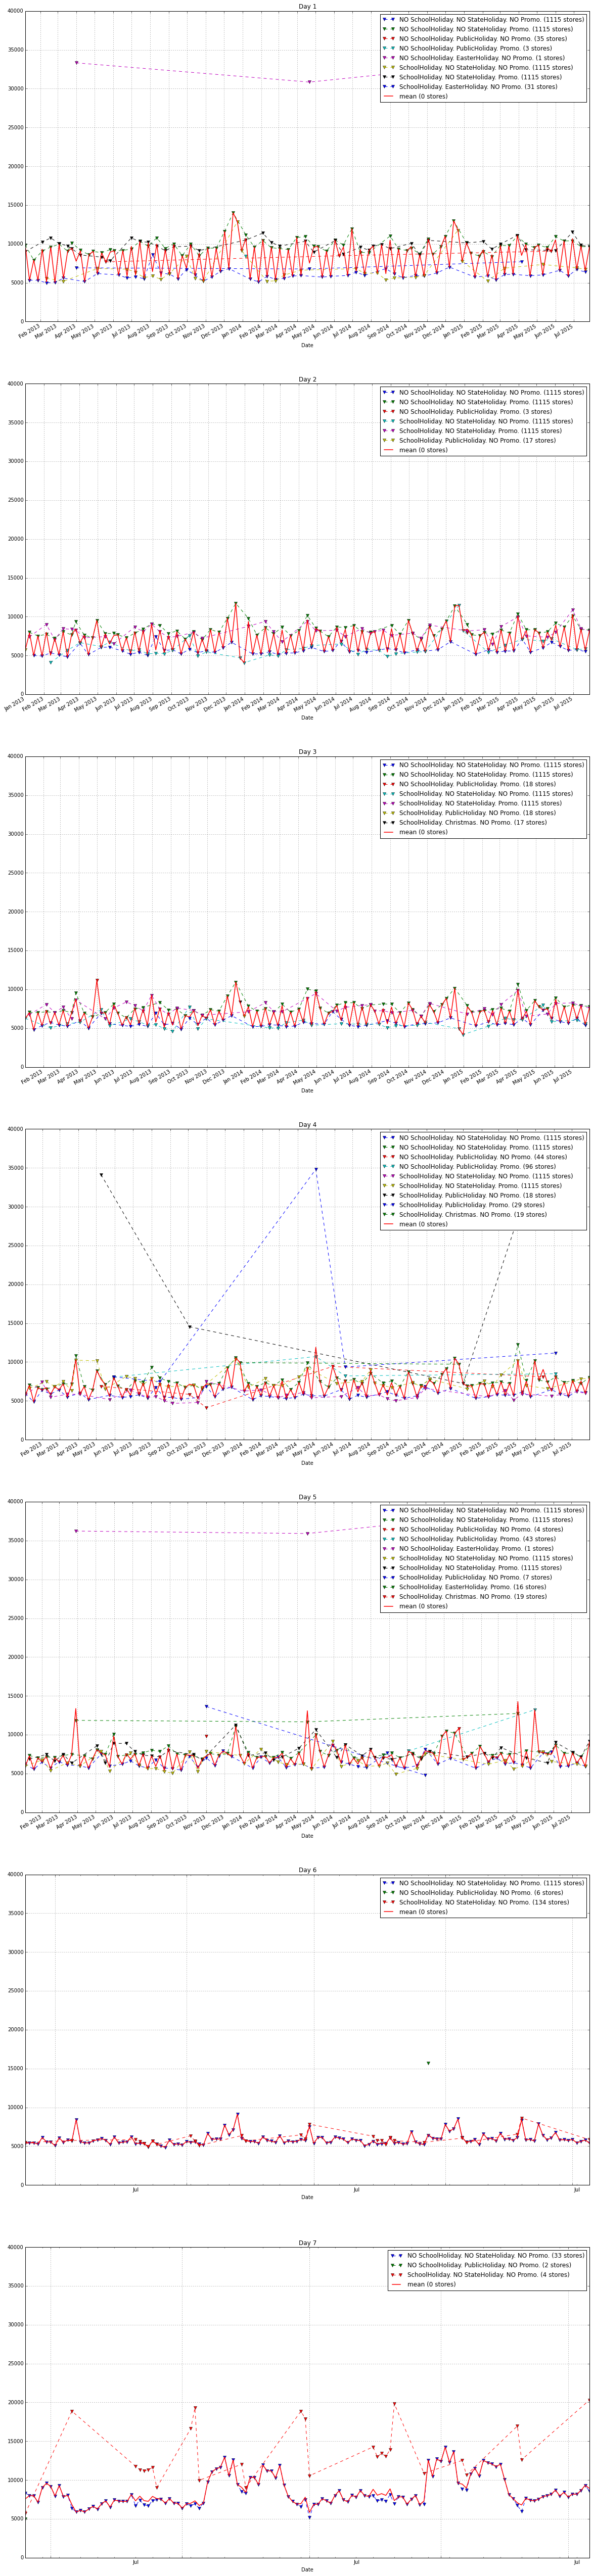

In [30]:
fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))
for day_of_week in range(1, 8):
    for school_holiday in [0, 1]:
        for state_holiday in ['0', 'a', 'b', 'c']:
            for promo_flag in [0, 1]:
                custom_df = train[(train['Open'] == 1) & 
                                  (train['DayOfWeek'] == day_of_week) &
                                  (train['Promo'] == promo_flag) & 
                                  (train['SchoolHoliday'] == school_holiday) & 
                                  (train['StateHoliday'] == state_holiday)]

                gp_date = custom_df.groupby('Date')
                gp_store = custom_df.groupby('Store')
                
                def construct_label_name(school_holiday, state_holiday, promo_flag, n_stores):
                    string_school = 'NO SchoolHoliday. '
                    string_state = 'NO StateHoliday. '
                    string_promo = 'NO Promo. '
                    if school_holiday == 1:
                        string_school = string_school[3:]
                    if promo_flag:
                        string_promo = string_promo[3:]
                    if state_holiday != '0':
                        string_state = {'a': 'PublicHoliday. ', 'b': 'EasterHoliday. ', 'c':'Christmas. '}[state_holiday]
                    string_stores = '(' + str(n_stores) + ' stores)'
                    return string_school + string_state + string_promo + string_stores
                
                if list(gp_date['Sales']):
                    ts_mean = gp_date['Sales'].mean()
                    ts_mean.plot(style='v--', ax=axes[day_of_week - 1], 
                                 label=construct_label_name(school_holiday, state_holiday,
                                                            promo_flag, len(gp_store)))
#                 else:
#                     print('There is no data for ', day_of_week, school_holiday, state_holiday, promo_flag)
    
                
    custom_df = train[(train['Open'] == 1) & (train['DayOfWeek'] == day_of_week)]
    gp_date = custom_df.groupby('Date')
    ts_mean = gp_date['Sales'].mean()
    ts_mean.plot(style='r-', linewidth=1.5, ax=axes[day_of_week - 1], label='mean (' + str(len(gp_store)) + ' stores)')
    axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
    axes[day_of_week - 1].legend()
    axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
    axes[day_of_week - 1].grid(True)
del fig
del axes

In [55]:
data_train = []
data_train_labels = []


def get_mean_dict(gp_date):
    return {'2013': gp_date['Sales'].mean()['2013-01-01':'2013-12-31'], 
            '2014': gp_date['Sales'].mean()['2014-01-01':'2014-12-31'], 
            '2015': gp_date['Sales'].mean()['2015-01-01':'2015-07-31']}
     
for day_of_week in range(1, 8):
    custom_df = train[(train['Open'] == 1) & (train['DayOfWeek'] == day_of_week)]
    gp_date = custom_df.groupby('Date')
    ts_week_mean = get_mean_dict(gp_date)
    
    for school_holiday in [0, 1]:
            for promo_flag in [0, 1]:
                custom_df = train[(train['Open'] == 1) & 
                                  (train['DayOfWeek'] == day_of_week) &
                                  (train['Promo'] == promo_flag) & 
                                  (train['SchoolHoliday'] == school_holiday)]

                gp_date = custom_df.groupby('Date')
                ts_mean= get_mean_dict(gp_date)
                for year in ['2013', '2014', '2015']:
                    if len(ts_mean[year]):
                        for index, value in ts_week_mean[year].iteritems():
                            if index not in ts_mean[year]:
                                ts_mean[year][index] = value
                        for index, value in ts_mean[year].iteritems():
                            data_train.append([index.month, index.day, promo_flag, school_holiday, day_of_week, value])

data_train = np.array(data_train)
                        
# test['Sales'] = 0
# for index, row in test.iterrows():
#     promo = row['Promo']
#     school_holiday = row['SchoolHoliday']
#     day_of_week = row['DayOfWeek']
    
#     break

array([[  1.00000000e+00,   1.40000000e+01,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   5.32740995e+03],
       [  1.00000000e+00,   2.80000000e+01,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   5.31048058e+03],
       [  2.00000000e+00,   1.10000000e+01,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   4.99165895e+03],
       ..., 
       [  7.00000000e+00,   5.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   7.00000000e+00,   8.15903030e+03],
       [  7.00000000e+00,   1.20000000e+01,   0.00000000e+00,
          1.00000000e+00,   7.00000000e+00,   8.65771875e+03],
       [  7.00000000e+00,   1.90000000e+01,   0.00000000e+00,
          1.00000000e+00,   7.00000000e+00,   9.32556250e+03]])